In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import torch
from torch import nn

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from multiclass_performanceMetrics import *
from dataMining_functions import *
from neuralNet_functions import *
from nested_design_analysis import *

/Users/chihoonlee/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
# load csv files containing slope of wavelet decomposition extracted from data based on discrete wavelet transform
slope_m = pd.read_csv('features/window512_neuron_slope_rowwindow_Molino.csv', header=None)
slope_p = pd.read_csv('features/window512_neuron_slope_rowwindow_Pachon.csv', header=None)
slope_s = pd.read_csv('features/window512_neuron_slope_rowwindow_Surface.csv', header=None)

In [5]:
slope_m

,0,1,2,3,4,5,6,7,8,9,...,869,870,871,872,873,874,875,876,877,878
0,-0.067605,-0.118922,-0.094129,0.066032,-0.238939,0.254376,-0.040246,-0.523493,0.087673,0.015258,...,0,0,0,0,0,0,0,0,0,0
1,0.332007,-0.134249,-0.199915,0.160182,-0.087102,0.085284,-0.115161,-0.078553,-0.028346,0.131704,...,0,0,0,0,0,0,0,0,0,0
2,-0.038976,-0.040227,0.055008,-0.038261,-0.154654,0.070836,-0.114923,0.036480,0.135799,0.022447,...,0,0,0,0,0,0,0,0,0,0
3,0.212578,0.135834,-0.017293,-0.067745,0.269292,-0.100228,0.107695,-0.215125,0.118761,-0.020157,...,0,0,0,0,0,0,0,0,0,0
4,-0.162624,-0.076423,-0.017957,0.056792,-0.081956,-0.101262,-0.147040,0.138392,0.080331,-0.032050,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,-0.066847,0.015115,-0.005959,0.140707,-0.069607,-0.107607,-0.848645,-0.110150,-0.414189,0.010325,...,0,0,0,0,0,0,0,0,0,0
172,0.016731,-0.081127,0.099292,-0.113153,0.166376,0.124942,-0.647028,-0.153044,-0.502469,-0.102382,...,0,0,0,0,0,0,0,0,0,0
173,0.065406,-0.255316,-0.078730,-0.139135,-0.008821,-0.238510,-0.553786,-0.415466,-0.494167,-0.203211,...,0,0,0,0,0,0,0,0,0,0
174,-0.180683,-0.158076,-0.078359,-0.168406,0.140557,-0.090916,-0.817421,-0.217100,0.018712,0.150379,...,0,0,0,0,0,0,0,0,0,0


In [6]:
min_col = 275  # minimum number of neurons of a fish in the data

# slicing the data set
slope_m = slope_m.iloc[:, :min_col]
slope_p = slope_p.iloc[:, :min_col]
slope_s = slope_s.iloc[:, :min_col]

# compute Hurst exponent
slope_m = (slope_m + 1)/2
slope_p = (slope_p + 1)/2
slope_s = (slope_s + 1)/2


# class lables
# molino = 0, pachon = 1, surface = 2
slope_m['class'] = 0
slope_p['class'] = 1
slope_s['class'] = 2
num_class = 3





In [7]:
slope_m.shape, slope_p.shape, slope_s.shape

((176, 276), (176, 276), (121, 276))

In [8]:
# get the number of nonoverlapping window obtained from the neural signal
num_window = slope_m.shape[0] / 16  # 16 is the number of fishes in molino group in the dataset
num_window

11.0

In [9]:
# combine all fish classes datasets
df = pd.concat([slope_m, slope_p], axis=0)
df = pd.concat([df, slope_s], axis=0)

In [10]:
# apply balanced nested design to the dataset
# to break the dependency caused by subjects(fishes) on the neural signals of a fish
df = balanced_nested_design_sampling(df, num_window=num_window)

# Classifications

In [11]:
# shuffle data set for more randomness during training
df = df.sample(frac=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,271,272,273,274,class
69,0.384940,0.451285,0.372008,0.428646,0.525543,0.455494,0.457477,0.429650,0.504209,0.368023,...,0.281967,0.322987,0.385743,0.332475,0.155166,0.433972,0.341146,0.442317,0.355509,0
118,0.544752,0.384391,0.472684,0.442481,0.507638,0.392794,0.235156,0.304316,0.264965,0.410443,...,0.540293,0.578526,0.513368,0.283942,0.280965,0.481574,0.506044,0.544905,0.070544,0
176,0.661155,0.378084,0.646773,0.626347,0.675446,0.298601,0.319276,0.587285,0.421165,0.531877,...,0.316298,0.237521,-0.223215,0.414069,-0.273443,0.052874,-0.114221,-0.350547,0.119786,1
249,0.574119,0.462792,0.441102,0.430258,0.475447,0.563074,0.501181,0.468070,0.475530,0.431873,...,0.435167,0.442507,0.505149,0.465673,0.478693,0.193796,0.371905,0.334567,0.427749,2
241,0.538471,0.670009,0.505034,0.539917,0.507642,0.501666,0.554198,0.406468,0.503254,0.536929,...,0.432896,0.156069,-0.069728,0.584353,0.018141,0.351083,0.509413,0.262663,0.475885,1


In [12]:
# train and test data split
X, y = df.drop(labels='class', axis=1), df['class']
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
# Apply SMOTE to balance the training data
# sometimes random train and test data split causes minor data imbalance
# not a big issue, but used SMOTE just in case
#sm = SMOTE(random_state=42, k_neighbors=12)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [14]:
def SMOTE_oversample(data):
    # param: data is a dataframe (normally training data) where the target feature is in the last column
    # return balanced data by applying SMOTE oversampling technique
    # this function will be used in repeat_sampling_and_training function
    #             to apply data preprocessing for every sample
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    sm = SMOTE(random_state=42, k_neighbors=12)
    X, y = sm.fit_resample(X, y)
    df = pd.concat([X, y], axis=1)
    df = df.sample(frac=1)
    return df

Feedforward Neural Network

In [15]:
# check whether a GPU is available and set the device to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [16]:
# split data into train and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=3)
# Apply SMOTE to balance the training data
# sometimes random train and test data split causes minor data imbalance
# not a big issue, but used SMOTE just in case
sm = SMOTE(random_state=42, k_neighbors=12)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(y_train.value_counts())

#train_d = pd.concat([X_train, y_train], axis=1)
#test_d = pd.concat([X_test, y_test], axis=1)

# form a pair of dataset and corresponding class labels
test_np = np.array(pd.concat([X_test, y_test], axis=1))
train_np = np.array(pd.concat([X_train, y_train], axis=1))
val_np = np.array(pd.concat([X_val, y_val], axis=1))

1    81
0    81
2    81
Name: class, dtype: int64


In [17]:
# simple feedforward NN
input_d = X_train.shape[1]
output_d = len(y_train.unique())
is_dropOut=True  # True means dropout layers will be applied
is_batchNorm=True  # True means batch norm will be applied
layers_dim = [input_d//3, input_d//9, input_d//27]  # dimension of NN layers excluding output layer
activations = [nn.ReLU(), nn.LeakyReLU(), nn.LeakyReLU()]  # activation functions for hidden layers
model = simpleNN(input_d, output_d, is_dropOut, is_batchNorm,
                 layers_dim=layers_dim, activations=activations)

In [18]:
model

simpleNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (layer1): Sequential(
    (0): Linear(in_features=275, out_features=91, bias=True)
    (1): BatchNorm1d(91, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (hidden_layers): Sequential(
    (hidden1): Sequential(
      (0): Linear(in_features=91, out_features=30, bias=True)
      (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (hidden2): Sequential(
      (0): Linear(in_features=30, out_features=10, bias=True)
      (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (output_layer): Linear(in_features=10, out_features=3, bias=True)
)

In [19]:
# hyper params
n_epochs=1000  # number of epochs
lr=0.0005  # learning rate
loss_f = nn.CrossEntropyLoss()  # loss function
loss_f.float()
weight_decay=0.25
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer

In [20]:
# training a feedforward neural network
es = simpleEarlyStopping(patience=20)
train_res = train(model, train_np, val_np, optimizer, loss_f, device,
            batch_size=64, n_epochs=n_epochs, ES=es, is_binary=False)

Epoch 10/1000
Train Loss: 0.7471	Train Accuracy: 0.8064
Validation Loss: 0.8397	Validation Accuracy: 0.8103
Epoch 20/1000
Train Loss: 0.6400	Train Accuracy: 0.9277
Validation Loss: 0.6871	Validation Accuracy: 0.8966
Epoch 30/1000
Train Loss: 0.5212	Train Accuracy: 0.9727
Validation Loss: 0.5835	Validation Accuracy: 0.9310
Epoch 40/1000
Train Loss: 0.4737	Train Accuracy: 0.9922
Validation Loss: 0.4930	Validation Accuracy: 0.9310
Epoch 50/1000
Train Loss: 0.4333	Train Accuracy: 0.9805
Validation Loss: 0.4366	Validation Accuracy: 0.9828
Epoch 60/1000
Train Loss: 0.4013	Train Accuracy: 0.9756
Validation Loss: 0.4048	Validation Accuracy: 0.9828
Epoch 70/1000
Train Loss: 0.3700	Train Accuracy: 0.9961
Validation Loss: 0.4139	Validation Accuracy: 1.0000
Epoch 80/1000
Train Loss: 0.3464	Train Accuracy: 0.9961
Validation Loss: 0.3420	Validation Accuracy: 1.0000
Epoch 90/1000
Train Loss: 0.3394	Train Accuracy: 1.0000
Validation Loss: 0.3570	Validation Accuracy: 1.0000
Epoch 100/1000
Train Loss: 0

Epoch 770/1000
Train Loss: 0.5406	Train Accuracy: 0.9961
Validation Loss: 0.6017	Validation Accuracy: 1.0000
Epoch 780/1000
Train Loss: 0.5192	Train Accuracy: 0.9961
Validation Loss: 0.5748	Validation Accuracy: 0.9655
Epoch 790/1000
Train Loss: 0.5426	Train Accuracy: 1.0000
Validation Loss: 0.5738	Validation Accuracy: 0.9655
Epoch 800/1000
Train Loss: 0.5295	Train Accuracy: 1.0000
Validation Loss: 0.5449	Validation Accuracy: 0.9655
Epoch 810/1000
Train Loss: 0.5419	Train Accuracy: 0.9922
Validation Loss: 0.5609	Validation Accuracy: 1.0000
Epoch 820/1000
Train Loss: 0.5218	Train Accuracy: 1.0000
Validation Loss: 0.5702	Validation Accuracy: 1.0000
Epoch 830/1000
Train Loss: 0.5359	Train Accuracy: 0.9922
Validation Loss: 0.5584	Validation Accuracy: 0.9828
Epoch 840/1000
Train Loss: 0.5310	Train Accuracy: 1.0000
Validation Loss: 0.5510	Validation Accuracy: 0.9655
Epoch 850/1000
Train Loss: 0.5278	Train Accuracy: 0.9951
Validation Loss: 0.5417	Validation Accuracy: 0.9828
Epoch 860/1000
Trai

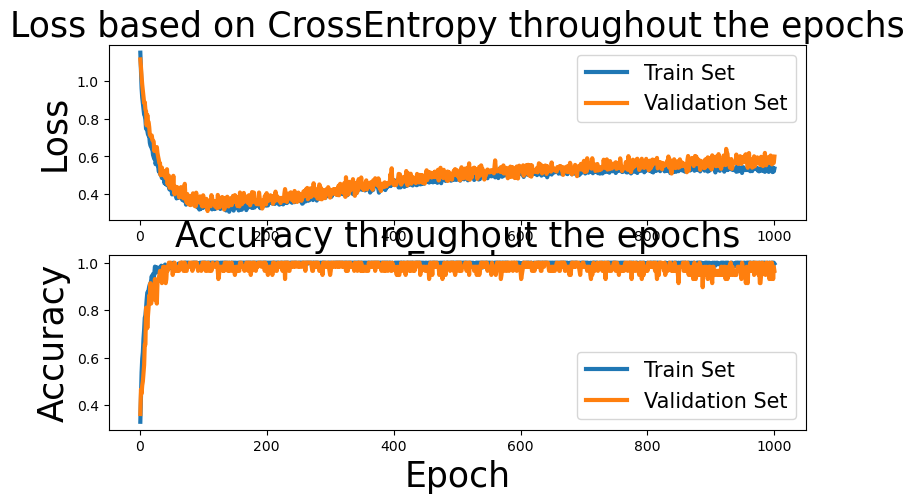

In [21]:
# plot training history
train_loss, val_loss, train_acc, val_acc = train_res
loss_fname = "CrossEntropy"
visualize_train_log(train_loss, val_loss, train_acc, val_acc, loss_fname)

In [22]:
# evaluate the model performance on training and testing data
train_true, train_pred = test(model, train_np, device, batch_size=512)
target_names = ['Molino', 'Pachon', 'Surface']
print(classification_report(train_true, train_pred, target_names=target_names))
confusion_matrix(train_true, train_pred)

              precision    recall  f1-score   support

      Molino       1.00      1.00      1.00        81
      Pachon       1.00      1.00      1.00        81
     Surface       1.00      1.00      1.00        81

    accuracy                           1.00       243
   macro avg       1.00      1.00      1.00       243
weighted avg       1.00      1.00      1.00       243



array([[81,  0,  0],
       [ 0, 81,  0],
       [ 0,  0, 81]])

In [23]:
test_true, test_pred = test(model, test_np, device, batch_size=512)
target_names = ['Molino', 'Pachon', 'Surface']
print(classification_report(test_true, test_pred, target_names=target_names))
confusion_matrix(test_true, test_pred)

              precision    recall  f1-score   support

      Molino       1.00      0.88      0.94        26
      Pachon       0.88      1.00      0.94        29
     Surface       1.00      0.94      0.97        18

    accuracy                           0.95        73
   macro avg       0.96      0.94      0.95        73
weighted avg       0.95      0.95      0.95        73



array([[23,  3,  0],
       [ 0, 29,  0],
       [ 0,  1, 17]])

CNN

In [30]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

2023-11-14 00:34:39.111968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
def oneHotEncode_class_lables(y, output_d):
    # param: y(array) is class labels
    # param: output_d(int) is the number of classes in the labels
    # return a one hot encoded class labels with the size of (length of y, output_d)
    y = np.array(y)
    vectorized_y = np.zeros((y.shape[0], output_d))
    for class_i in range(output_d):
        is_y_class_i = y == class_i
        vectorized_y[:, class_i] = is_y_class_i
    return vectorized_y
# reshaping data matrix because CNN expects at least 3-dimensional tensor
X_train = np.array(X_train)
X_train = X_train[:, :, np.newaxis]
#y_train = oneHotEncode_class_lables(y_train, output_d)

X_val = np.array(X_val)
X_val = X_val[:, :, np.newaxis]
#y_val = oneHotEncode_class_lables(y_val, output_d)

X_test = np.array(X_test)
X_test = X_test[:, :, np.newaxis]
#y_test = oneHotEncode_class_lables(y_test, output_d)

In [32]:
from math import floor

kernel_size = 2**floor(np.log2(X_train.shape[1]//16))
kernel_size

16

In [33]:
class Conv1D_block(layers.Layer):
    def __init__(self, **kwargs):
        # build a block for 1D convolution layer, batch normalization, activation layer, etc.
        super().__init__()
        self.kernel_size = kwargs.get("kernel_size", 10)  # convolution kernel block size (int)
        self.filters = kwargs.get("filters", 2)  # number of feature maps (int)
        self.activation = kwargs.get("activation", "relu")  # activation function name(string)
        self.conv1d = layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size)
        self.batch_norm = layers.BatchNormalization()
        self.activation = layers.Activation(self.activation)
        # the size of pooling block in pooling layer. If 0, no max pooling layer after convolutional layer
        self.pooling_size = kwargs.get("pooling_size", 0)
        self.maxpool = layers.MaxPooling1D(self.pooling_size)
    
    def get_config(self):
        # config required for custom layer
        config = super().get_config()
        config.update({
            "pooling_size": self.pooling_size,
            "kernel_size": self.kernel_size,
            "filters": self.filters,
            "activation": self.activation,
        })
        return config
    
    def call(self, x):
        # param: x is a input data
        # return a value after forward passing through this block
        x = self.conv1d(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        if self.pooling_size:
            x = self.maxpool(x)
        return x

In [34]:
# build a CNN model
inputs = keras.Input(shape=(X_train.shape[1:]))
conv1 = Conv1D_block(filters=4, kernel_size=kernel_size, pooling_size=2)
x = conv1(inputs)
conv2 = Conv1D_block(filters=8, kernel_size=kernel_size, pooling_size=2)
x = conv2(x)
x = layers.Flatten()(x)
x = layers.Dense(16)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(output_d, activation="softmax")(x)
cnn = keras.Model(inputs=inputs, outputs=outputs)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 275, 1)]          0         
                                                                 
 conv1d_block (Conv1D_block)  (None, 130, 4)           84        
                                                                 
 conv1d_block_1 (Conv1D_bloc  (None, 57, 8)            552       
 k)                                                              
                                                                 
 flatten (Flatten)           (None, 456)               0         
                                                                 
 dense (Dense)               (None, 16)                7312      
                                                                 
 batch_normalization_2 (Batc  (None, 16)               64        
 hNormalization)                                             

2023-11-14 00:34:41.359607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
# hyper params setting
lr = 0.01
optim = tf.keras.optimizers.RMSprop(learning_rate=lr)
cnn.compile(
    optimizer=optim,
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'],
)

# training a model
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="cnn_hurst.keras", monitor='val_loss',
                                    saves_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-7, verbose=1),
]
history = cnn.fit(X_train, y_train,
                          epochs=100,
                          validation_data=(X_val, y_val),
                          callbacks=callbacks)

Epoch 1/100
8/8 [==============================] - 1s 32ms/step - loss: 1.0875 - accuracy: 0.4979 - val_loss: 1.0448 - val_accuracy: 0.3966 - lr: 0.0100
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.6321 - accuracy: 0.7613 - val_loss: 1.0915 - val_accuracy: 0.3793 - lr: 0.0100
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.4541 - accuracy: 0.8230 - val_loss: 1.0359 - val_accuracy: 0.4138 - lr: 0.0100
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.3556 - accuracy: 0.8519 - val_loss: 1.0578 - val_accuracy: 0.4310 - lr: 0.0100
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.3004 - accuracy: 0.8889 - val_loss: 0.9401 - val_accuracy: 0.4310 - lr: 0.0100
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.2174 - accuracy: 0.9218 - val_loss: 0.8410 - val_accuracy: 0.5172 - lr: 0.0100
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1907 - a

Epoch 51/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0496 - accuracy: 0.9794 - val_loss: 0.1827 - val_accuracy: 0.9310 - lr: 1.0000e-05
Epoch 52/100
1/8 [==>...........................] - ETA: 0s - loss: 0.0581 - accuracy: 0.9688
Epoch 52: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
8/8 [==============================] - 0s 11ms/step - loss: 0.0795 - accuracy: 0.9630 - val_loss: 0.1649 - val_accuracy: 0.9655 - lr: 1.0000e-05
Epoch 52: early stopping


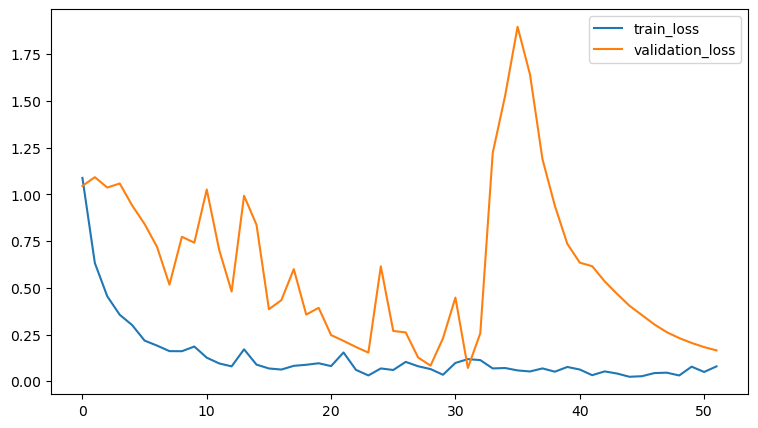

In [36]:
# plot the training history
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, val_loss, label="validation_loss")
plt.legend()
plt.show()

In [37]:
# load the best model during the training
model = keras.models.load_model("cnn_hurst.keras", {
    "Conv1D_block": Conv1D_block,
})

In [38]:
results = model.evaluate(X_test, y_test)
print(f"testing loss: {results[0]}, testing accuracy: {results[1]}")

3/3 [==============================] - 0s 2ms/step - loss: 0.2158 - accuracy: 0.9452
testing loss: 0.21582375466823578, testing accuracy: 0.9452054500579834


In [39]:
# evaluate the model performance on training and testing data
train_pred = np.argmax(model.predict(X_train), axis=1)
target_names = ['Molino', 'Pachon', 'Surface']
print(classification_report(y_train, train_pred, target_names=target_names))
confusion_matrix(y_train, train_pred)

8/8 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

      Molino       1.00      1.00      1.00        81
      Pachon       1.00      1.00      1.00        81
     Surface       1.00      1.00      1.00        81

    accuracy                           1.00       243
   macro avg       1.00      1.00      1.00       243
weighted avg       1.00      1.00      1.00       243



array([[81,  0,  0],
       [ 0, 81,  0],
       [ 0,  0, 81]])

In [40]:
test_pred = np.argmax(model.predict(X_test), axis=1)
target_names = ['Molino', 'Pachon', 'Surface']
print(classification_report(y_test, test_pred, target_names=target_names))
confusion_matrix(y_test, test_pred)

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

      Molino       1.00      0.96      0.98        26
      Pachon       1.00      0.90      0.95        29
     Surface       0.82      1.00      0.90        18

    accuracy                           0.95        73
   macro avg       0.94      0.95      0.94        73
weighted avg       0.96      0.95      0.95        73



array([[25,  0,  1],
       [ 0, 26,  3],
       [ 0,  0, 18]])